# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

In [2]:
df = pd.read_csv("nhanes_2015_2016.csv")

In [3]:
df.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,1.0,2,134671.37,1,125,4.39,128.0,70.0,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,3.0,1,24328.56,1,125,1.32,146.0,88.0,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,1.0,2,12400.01,1,131,1.51,138.0,46.0,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,6.0,1,102718.00,1,131,5.00,132.0,72.0,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,3.0,5,17627.67,2,126,1.23,100.0,70.0,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5735 non-null   int64  
 1   ALQ101    5208 non-null   float64
 2   ALQ110    1731 non-null   float64
 3   ALQ130    3379 non-null   float64
 4   SMQ020    5735 non-null   int64  
 5   RIAGENDR  5735 non-null   int64  
 6   RIDAGEYR  5735 non-null   int64  
 7   RIDRETH1  5735 non-null   int64  
 8   DMDCITZN  5734 non-null   float64
 9   DMDEDUC2  5474 non-null   float64
 10  DMDMARTL  5474 non-null   float64
 11  DMDHHSIZ  5735 non-null   int64  
 12  WTINT2YR  5735 non-null   float64
 13  SDMVPSU   5735 non-null   int64  
 14  SDMVSTRA  5735 non-null   int64  
 15  INDFMPIR  5134 non-null   float64
 16  BPXSY1    5401 non-null   float64
 17  BPXDI1    5401 non-null   float64
 18  BPXSY2    5535 non-null   float64
 19  BPXDI2    5535 non-null   float64
 20  BMXWT     5666 non-null   floa

## Question 1

### Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [5]:
# getting sample of data for ages 35 to 50
df_35to50 = df.query("RIDAGEYR >= 35 & RIDAGEYR <= 50")

df_35to50['RIDAGEYR'].describe()

count    1451.000000
mean       42.379049
std         4.612242
min        35.000000
25%        38.000000
50%        42.000000
75%        46.000000
max        50.000000
Name: RIDAGEYR, dtype: float64

In [6]:
# getting only females
df_35to50_FEM = df_35to50.query("RIAGENDR == 2")

In [7]:
df_35to50_FEM.DMDMARTL.unique()

array([3., 1., 4., 5., 6., 2.])

In [8]:
# splitting DMDMARTL into currently married and not married
maritalStat = {1:'Curr. Married', 2:'Not Married', 3:'Not Married', 4:'Not Married',
               5:'Not Married', 6:'Not Married'}
df_35to50_FEM['DMDMARTLx'] = df_35to50_FEM.DMDMARTL.replace(maritalStat)

# adding meaning to DMDEDUC2 column
df_35to50_FEM["DMDEDUC2x"] = df_35to50_FEM.DMDEDUC2.replace({1: "Non College Grad", 2: "Non College Grad", 3: "Non College Grad", 4: "Non College Grad", 5: "College Grad", 
                                                             7: "Non College Grad", 9: "Non College Grad"})

df_35to50_FEM.DMDMARTLx.unique()

array(['Not Married', 'Curr. Married'], dtype=object)

In [9]:
# Calculate the count per category
n = pd.crosstab(df_35to50_FEM.DMDMARTLx, df_35to50_FEM.DMDEDUC2x).sum(axis=1)
n

DMDMARTLx
Curr. Married    449
Not Married      338
dtype: int64

In [10]:
# Calculate the proportion that completed college
p = pd.crosstab(df_35to50_FEM.DMDMARTLx, df_35to50_FEM.DMDEDUC2x, normalize='index')
p

DMDEDUC2x,College Grad,Non College Grad
DMDMARTLx,,
Curr. Married,0.360802,0.639198
Not Married,0.213018,0.786982


From our data, the percentage of females between the ages of 35-50 that are married and have completed their college degrees is 36% while for those that are not married, just 21% of them are college graduates.

In [11]:
# calculate standard errors for 'Curr. Married' and 'Not Married' distributions
se_married = np.sqrt(p.iloc[0,0] * (1 - p.iloc[0,0]) / n[0])
se_notMarried = np.sqrt(p.iloc[1,0] * (1 - p.iloc[1,0]) / n[1])

(se_married, se_notMarried)

(0.02266360248455356, 0.022270605048202215)

In [12]:
# manual calculation
print("Currently Married")
print('Lower Boundary: ', p.iloc[0,0]-1.96*se_married)
print('Upper Boundary: ', p.iloc[0,0]+1.96*se_married)
print("\nNot Married")
print('Lower Boundary: ', p.iloc[1,0]-1.96*se_notMarried)
print('Upper Boundary: ', p.iloc[1,0]+1.96*se_notMarried)

Currently Married
Lower Boundary:  0.3163811208674688
Upper Boundary:  0.4052224426069187

Not Married
Lower Boundary:  0.1693673655848136
Upper Boundary:  0.25666813737376626


In [13]:
# using proportion_confint to calculate a 95% confidence interval
print('Curr. Married')
## proportion_confint(no of successes, total no of trial)
ci_low, ci_upp = proportion_confint(p.iloc[0,0]*n[0], n[0], alpha=0.05, method='normal')
print(f"{ci_low}, {ci_upp}")

print('\nNot Married')
ci_low, ci_upp = proportion_confint(p.iloc[1,0]*n[1], n[1], alpha=0.05, method='normal')
print(f"{ci_low}, {ci_upp}")

Curr. Married
0.31638193710753626, 0.4052216263668512

Not Married
0.16936816767089768, 0.2566673352876822


#### Q1a. Identify which of the two confidence intervals is wider, and explain why this is the case. 

The confidence interval for unmarried women with a college degree (0.169 to 0.257) is wider than the confidence interval for currently married women with a college degree (0.316 to 0.405).

The width of a confidence interval is determined by several factors, including the sample size and the proportion of the sample with the characteristic of interest. In this case, the sample size for unmarried women (n = 338) is smaller than the sample size for currently married women (n = 449), which tends to result in wider confidence intervals. Additionally, the proportion of unmarried women with a college degree (p = 0.21) is lower than the proportion of currently married women with a college degree (p = 0.36), which also contributes to a wider confidence interval. The wider interval for the unmarried women suggests that we have less certainty about the true proportion of unmarried women with a college degree compared to the proportion of currently married women with a college degree.

#### Q1b. Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

The findings suggest that among the sample of women aged 35 to 50 years old, a higher proportion of currently married women have completed college compared to unmarried women. The confidence intervals indicate that we are 95% confident that the true proportion of currently married women with a college education falls between 32% and 41%, while the true proportion of unmarried women with a college education falls between 17% and 26%.

The difference in proportions between the two groups may be attributed to a variety of factors. For example, married women may have more financial support from their spouse, allowing them to pursue higher education. Alternatively, unmarried women may face greater challenges in balancing their education with other responsibilities such as work or caring for children.

## Question 2

### Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

In [14]:
df.SMQ020.unique()

array([1, 2, 7, 9], dtype=int64)

In [15]:
# '1' represents those who selected 'Yes' to having smoked at least 100 cigarettes
# in life
df_smokers = df.query("SMQ020 == 1")
df_smokers.reset_index(inplace=True, drop=True)

In [16]:
smokers_gender = df_smokers['RIAGENDR']

# calculate number of null values
smokers_gender.isna().sum()

0

In [17]:
n_smokers = len(smokers_gender)
n_smokers_Male = sum(smokers_gender==1)
n_smokers_Female = sum(smokers_gender==2)

(n_smokers, n_smokers_Male, n_smokers_Female)

(2319, 1413, 906)

In [18]:
prop_smokersMale = n_smokers_Male/n_smokers
prop_smokersFemale = n_smokers_Female/n_smokers

(prop_smokersMale, prop_smokersFemale)

(0.6093143596377749, 0.3906856403622251)

In [19]:
se_smokersMale = np.sqrt(prop_smokersMale * (1 - prop_smokersMale) / n_smokers_Male)
se_smokersFemale = np.sqrt(prop_smokersFemale * (1 - prop_smokersFemale) / n_smokers_Female)

(se_smokersMale, se_smokersFemale)

(0.012979661011895138, 0.016209526631489866)

In [20]:
# manual calculation
print("Male Smokers")
print('Lower Boundary: ', prop_smokersMale-1.96*se_smokersMale)
print('Upper Boundary: ', prop_smokersMale+1.96*se_smokersMale)
print("\nFemale Smokers")
print('Lower Boundary: ', prop_smokersFemale-1.96*se_smokersFemale)
print('Upper Boundary: ', prop_smokersFemale+1.96*se_smokersFemale)

Male Smokers
Lower Boundary:  0.5838742240544604
Upper Boundary:  0.6347544952210894

Female Smokers
Lower Boundary:  0.35891496816450497
Upper Boundary:  0.4224563125599452


In [21]:
# using proportion_confint to calculate a 95% confidence interval
print('Male Smokers')
## proportion_confint(no of successes, total no of trial)
ci_low, ci_upp = proportion_confint(n_smokers_Male, n_smokers, alpha=0.05, method='normal')
print(f"{ci_low}, {ci_upp}")

print('\nFemale Smokers')
ci_low, ci_upp = proportion_confint(n_smokers_Female, n_smokers, alpha=0.05, method='normal')
print(f"{ci_low}, {ci_upp}")

Male Smokers
0.5894565132052486, 0.6291722060703012

Female Smokers
0.37082779392969883, 0.41054348679475133


In [27]:
## calculating the 95% confidence interval for the difference between
## the male proportion and the female proportion

se_diff = np.sqrt(se_smokersMale**2 + se_smokersFemale**2)
se_diff

0.020765845843612775

In [28]:
prop_diff = prop_smokersMale - prop_smokersFemale
prop_diff

0.21862871927554983

In [34]:
print("CI for Prop Difference Between Both Genders")
print('Lower Boundary: ', prop_diff-1.96*se_diff)
print('Upper Boundary: ', prop_diff+1.96*se_diff)
print("Width of CI: ", 2*1.96*se_diff)

CI for Prop Difference Between Both Genders
Lower Boundary:  0.17792766142206878
Upper Boundary:  0.2593297771290309
Width of CI:  0.08140211570696207


#### Q2a. Why might it be relevant to report the separate gender proportions **and** the difference between the gender proportions?

Reporting separate gender proportions and the difference between them is relevant because it provides a more detailed understanding of the characteristics of the population being studied. In this case, the NHANES dataset includes information about both male and female smokers, so it is important to report the proportion of smokers who are female and the proportion of smokers who are male separately. This information can help identify potential gender-related differences in smoking behavior.

Additionally, reporting the difference between the two gender proportions allows for a direct comparison of the smoking behavior between males and females. If the difference is statistically significant, it suggests that there may be a meaningful difference in smoking behavior between the two groups.

Furthermore, the confidence intervals provide a range of plausible values for each proportion and the difference between them. This range can be used to assess the precision of the estimates and to help draw conclusions about the population being studied.

#### Q2b. How does the **width** of the confidence interval for the difference between the gender proportions compare to the widths of the confidence intervals for the separate gender proportions?

The confidence interval for the difference of the two proportions is wider than the confidence intervals for each proportion separately

## Question 3

### Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [35]:
heightValues_cm = df['BMXHT']

In [44]:
heightValues_cm.isna().sum()

62

In [46]:
heightValues_cm = heightValues_cm.dropna()
heightValues_cm.reset_index(inplace=True, drop=True)

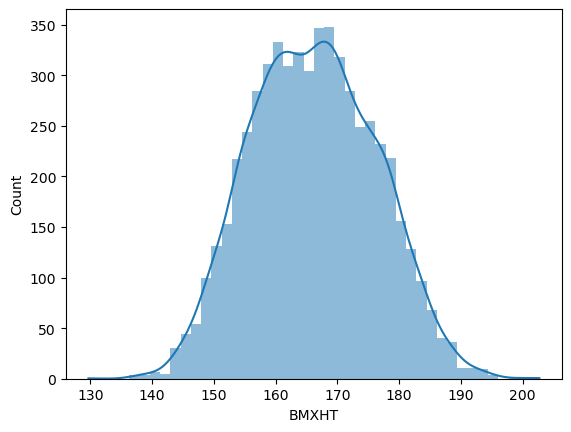

In [48]:
sns.histplot(heightValues_cm, kde=True, edgecolor=None);

In [49]:
heightValues_cm_mean = np.mean(heightValues_cm)
heightValues_cm_std = np.std(heightValues_cm)

(heightValues_cm_mean, heightValues_cm_std)

(166.14283447911131, 10.078375319383905)

In [50]:
# converting cm to in
heightValues_in = heightValues_cm/2.54

heightValues_in_mean = np.mean(heightValues_in)
heightValues_in_std = np.std(heightValues_in)

(heightValues_in_mean, heightValues_in_std)

(65.41056475555557, 3.9678642989700457)

In [53]:
lcb = heightValues_in_mean - 1.96*(heightValues_in_std/np.sqrt(len(heightValues_in)))
ucb = heightValues_in_mean + 1.96*(heightValues_in_std/np.sqrt(len(heightValues_in)))

print('Lower Boundary Inches: ', lcb)
print('Upper Boundary Inches: ', ucb)

Lower Boundary Inches:  65.30731084935765
Upper Boundary Inches:  65.51381866175349


In [55]:
print('Lower Boundary Centimeters: ', lcb*2.54)
print('Upper Boundary Centimeters: ', ucb*2.54)

Lower Boundary Centimeters:  165.88056955736843
Upper Boundary Centimeters:  166.40509940085386


In [56]:
# compare to calculate val
sm.stats.DescrStatsW(heightValues_cm).tconfint_mean()

(165.8804952776014, 166.40517368062174)

#### Q3a. Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

Both confidence intervals are very narrow and the sample mean of inches and cms fall inside the population confidence interval.

## Question 4

### Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [58]:
df['RIAGENDRx'] = df.RIAGENDR.replace({1:'Male', 2:'Female'})

In [65]:
# Calculate the mean, SD, and sample size for BMI within age/gender groups
labels = ['18-28','29-38','39-48','49-58','59-68','69-78','79-88']
df["agegrp"] = pd.cut(x=df.RIDAGEYR, bins=[18, 28, 38, 48, 58, 68, 78, 88],labels=labels)
pr = df.groupby(["agegrp", "RIAGENDRx"]).agg({"BMXBMI": [np.mean, np.std, np.size]})
pr

BMXBMI               
                       mean       std size
agegrp RIAGENDRx                          
18-28  Female     28.019433  8.048854  498
       Male       27.058186  6.679515  458
29-38  Female     29.943443  7.959097  494
       Male       29.697180  6.726690  467
39-48  Female     31.003733  8.044642  514
       Male       29.514646  6.104950  398
49-58  Female     30.787361  7.647590  454
       Male       29.385132  6.151534  419
59-68  Female     31.054664  7.779502  466
       Male       29.232462  5.959024  470
69-78  Female     30.537818  6.780588  279
       Male       28.720270  5.336652  307
79-88  Female     27.850000  5.483781  201
       Male       27.464368  4.695650  177

In [66]:
pr = pr.unstack()
pr

BMXBMI                                           
                mean                  std             size     
RIAGENDRx     Female       Male    Female      Male Female Male
agegrp                                                         
18-28      28.019433  27.058186  8.048854  6.679515    498  458
29-38      29.943443  29.697180  7.959097  6.726690    494  467
39-48      31.003733  29.514646  8.044642  6.104950    514  398
49-58      30.787361  29.385132  7.647590  6.151534    454  419
59-68      31.054664  29.232462  7.779502  5.959024    466  470
69-78      30.537818  28.720270  6.780588  5.336652    279  307
79-88      27.850000  27.464368  5.483781  4.695650    201  177

In [67]:
# Calculate the SEM for females and for males within each age band
pr["BMXBMI", "sem", "Female"] = pr["BMXBMI", "std", "Female"] / np.sqrt(pr["BMXBMI", "size", "Female"]) 
pr["BMXBMI", "sem", "Male"] = pr["BMXBMI", "std", "Male"] / np.sqrt(pr["BMXBMI", "size", "Male"])
pr

BMXBMI                                                       \
                mean                  std             size            sem   
RIAGENDRx     Female       Male    Female      Male Female Male    Female   
agegrp                                                                      
18-28      28.019433  27.058186  8.048854  6.679515    498  458  0.360678   
29-38      29.943443  29.697180  7.959097  6.726690    494  467  0.358097   
39-48      31.003733  29.514646  8.044642  6.104950    514  398  0.354834   
49-58      30.787361  29.385132  7.647590  6.151534    454  419  0.358919   
59-68      31.054664  29.232462  7.779502  5.959024    466  470  0.360378   
69-78      30.537818  28.720270  6.780588  5.336652    279  307  0.405943   
79-88      27.850000  27.464368  5.483781  4.695650    201  177  0.386796   

                     
                     
RIAGENDRx      Male  
agegrp               
18-28      0.312113  
29-38      0.311274  
39-48      0.306014  
49-58      0.300522  
59-68      0.274869  
69-78      0.304579  
79-88      0.352947

In [69]:
# Calculate the mean difference of BMI between females and males within each age band, also  calculate
# its SE and the lower and upper limits of its 95% CI.
pr["BMXBMI", "mean_diff", ""] = pr["BMXBMI", "mean", "Female"] - pr["BMXBMI", "mean", "Male"]
pr["BMXBMI", "sem_diff", ""] = np.sqrt(pr["BMXBMI", "sem", "Female"]**2 + pr["BMXBMI", "sem", "Male"]**2) 
pr["BMXBMI", "lcb_diff", ""] = pr["BMXBMI", "mean_diff", ""] - 1.96 * pr["BMXBMI", "sem_diff", ""] 
pr["BMXBMI", "ucb_diff", ""] = pr["BMXBMI", "mean_diff", ""] + 1.96 * pr["BMXBMI", "sem_diff", ""] 
pr["BMXBMI", "Width of CI", ""] = pr["BMXBMI", "ucb_diff", ""] - pr["BMXBMI", "lcb_diff", ""]
pr

BMXBMI                                                       \
                mean                  std             size            sem   
RIAGENDRx     Female       Male    Female      Male Female Male    Female   
agegrp                                                                      
18-28      28.019433  27.058186  8.048854  6.679515    498  458  0.360678   
29-38      29.943443  29.697180  7.959097  6.726690    494  467  0.358097   
39-48      31.003733  29.514646  8.044642  6.104950    514  398  0.354834   
49-58      30.787361  29.385132  7.647590  6.151534    454  419  0.358919   
59-68      31.054664  29.232462  7.779502  5.959024    466  470  0.360378   
69-78      30.537818  28.720270  6.780588  5.336652    279  307  0.405943   
79-88      27.850000  27.464368  5.483781  4.695650    201  177  0.386796   

                                                                         
                    mean_diff  sem_diff  lcb_diff  ucb_diff Width of CI  
RIAGENDRx      Male                                                      
agegrp                                                                   
18-28      0.312113  0.961247  0.476973  0.026381  1.896114    1.869734  
29-38      0.311274  0.246263  0.474473 -0.683705  1.176230    1.859935  
39-48      0.306014  1.489086  0.468563  0.570703  2.407470    1.836767  
49-58      0.300522  1.402230  0.468120  0.484714  2.319745    1.835031  
59-68      0.274869  1.822202  0.453239  0.933853  2.710551    1.776698  
69-78      0.304579  1.817548  0.507502  0.822844  2.812252    1.989407  
79-88      0.352947  0.385632  0.523624 -0.640672  1.411936    2.052608

#### Q4a. How do the widths of these confidence intervals differ?  Provide an explanation for any substantial diferences in the confidence interval widths that you see.

The confidence interval width for the age groups is fairly equal except for the age group [79-88] where the width is much larger between females and males.

## Question 5

### Construct a 95% confidence interval for the first and second systolic blood pressure measures, and for the difference between the first and second systolic blood pressure measurements within a subject.

In [77]:
# creating subset
first_sbp = df['BPXSY1']
second_sbp = df['BPXSY2']
sbp_diff = first_sbp - second_sbp

# removing null values
first_sbp=first_sbp.dropna()
first_sbp.reset_index(inplace=True, drop=True)
second_sbp=second_sbp.dropna()
second_sbp.reset_index(inplace=True, drop=True)
sbp_diff=sbp_diff.dropna()
sbp_diff.reset_index(inplace=True, drop=True)

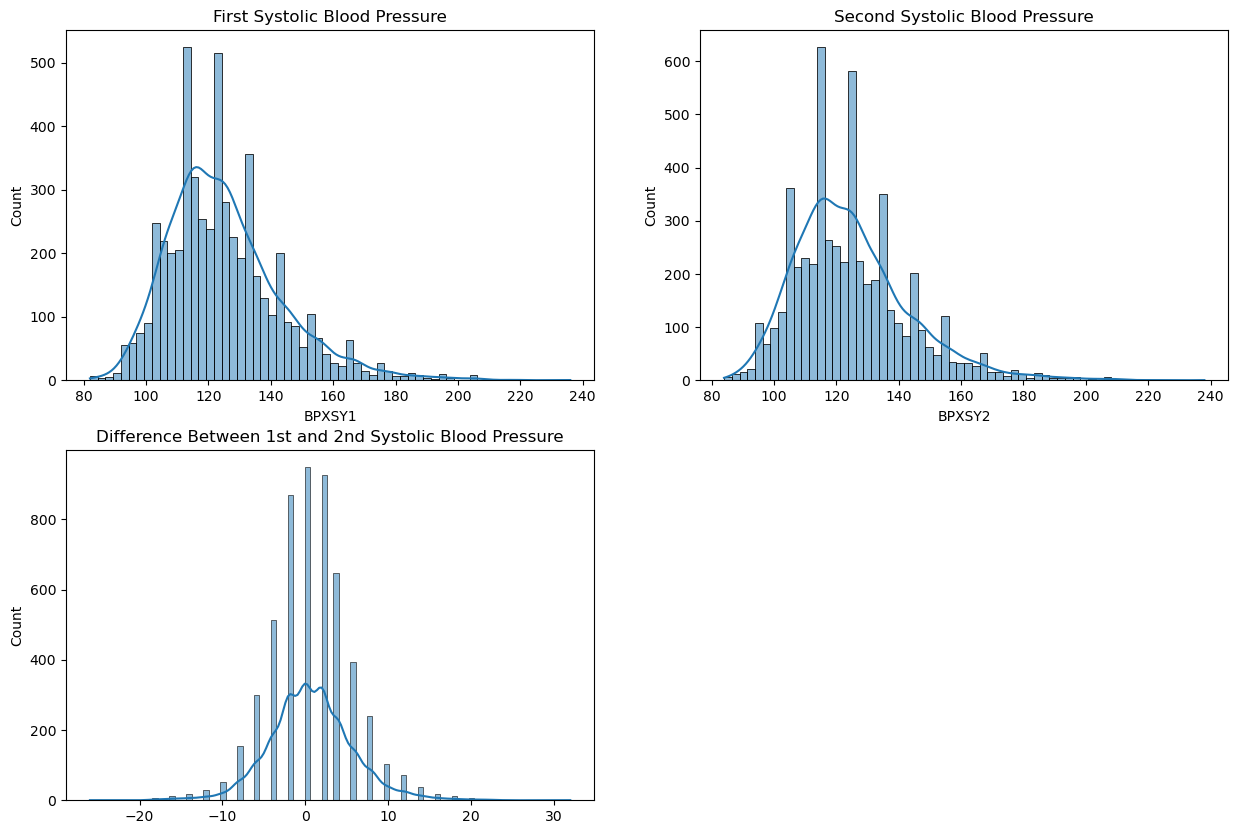

In [94]:
# visualizing distribution
# Set up the figure for plotting
plt.figure(figsize=(15,10))

# Plot the UofM students only
plt.subplot(2,2,1)
sns.histplot(first_sbp, kde=True)
plt.title("First Systolic Blood Pressure")

# Plot the Gym Goers only
plt.subplot(2,2,2)
sns.histplot(second_sbp, kde=True)
plt.title("Second Systolic Blood Pressure")

# Plot both groups together
plt.subplot(2,2,3)
sns.histplot(sbp_diff, kde=True)
plt.title("Difference Between 1st and 2nd Systolic Blood Pressure")


plt.show()

In [96]:
lower, upper = sm.stats.DescrStatsW(first_sbp).tconfint_mean()
print("First Systolic Blood Pressure")
print(f"95% CI: {lower}, {upper}")
print("CI Width: ", upper-lower)

First Systolic Blood Pressure
95% CI: 124.59163222328895, 125.57759569746646
CI Width:  0.9859634741775096


In [97]:
lower, upper = sm.stats.DescrStatsW(second_sbp).tconfint_mean()
print("Second Systolic Blood Pressure")
print(f"95% CI: {lower}, {upper}")
print("CI Width: ", upper-lower)

Second Systolic Blood Pressure
95% CI: 124.29482629577244, 125.27120803123749
CI Width:  0.9763817354650541


In [98]:
lower, upper = sm.stats.DescrStatsW(sbp_diff).tconfint_mean()
print("Systolic Blood Pressure Mean Difference (1st - 2nd)")
print(f"95% CI: {lower}, {upper}")
print("CI Width: ", upper-lower)

Systolic Blood Pressure Difference (1st - 2nd)
95% CI: 0.5399696008802797, 0.8100024609561889
CI Width:  0.2700328600759092


#### Q5a. Based on these confidence intervals, would you say that a difference of zero between the population mean values of the first and second systolic blood pressure measures is consistent with the data?

The confidence intervals gotten for the first and second systolic blood pressure measurements do overlap, which means that a difference of zero between the population mean values of these two measurements is consistent with the data. 

However, the confidence interval for the difference between the first and second measurements within each subject does not overlap with zero, indicating that there is likely a significant difference between the two measurements within each subject. Therefore, while the data may not provide evidence of a difference between the population mean values of the first and second systolic blood pressure measures, it does suggest that there is a difference within subjects, which could have important clinical implications.

#### Q5b. Discuss how the width of the confidence interval for the within-subject difference compares to the widths of the confidence intervals for the first and second measures.

Comparing the widths of the confidence intervals for the within-subject difference and the first and second measures can provide insights into the variability of these measures and the precision of the estimate of the difference between the first and second measurements.

The width of the confidence interval for the within-subject difference is (0.54, 0.81), which has a range of 0.27. This is narrower than the width of the confidence intervals for the first and second measures, which have ranges of 0.99 and 0.98, respectively.

The narrower width of the confidence interval for the within-subject difference suggests that the difference between the first and second measurements is estimated with greater precision than the individual measurements themselves. This could be due to a reduction in variability introduced by using each subject as their own control, which allows for a more precise estimation of the difference between measurements.

Overall, the narrower confidence interval for the within-subject difference compared to the confidence intervals for the individual measures suggests that measuring the same variable twice in each subject can provide more precise information about the difference between the two measurements than measuring the variable only once.

## Question 6

### Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [102]:
# getting age data from subset of smokers
smokers_age = df.query('SMQ020==1')['RIDAGEYR']
# removing null values
smokers_age = smokers_age.dropna()
smokers_age.reset_index(inplace=True, drop=True)

# getting age data from subset of non-smokers
nonsmokers_age = df.query('SMQ020!=1')['RIDAGEYR']
# removing null values
nonsmokers_age = nonsmokers_age.dropna()
nonsmokers_age.reset_index(inplace=True, drop=True)

In [103]:
sm.stats.DescrStatsW(smokers_age)

In [104]:
# create 'DescrStatsW' object
smokers_age_temp=sm.stats.DescrStatsW(smokers_age)
non_smokers_age_temp=sm.stats.DescrStatsW(nonsmokers_age)

# create a 'CompareMeans' object which performs the two-sample t-test and computes the
# confidence interval for the diff btwn the means of the two groups
cm = sm.stats.CompareMeans(smokers_age_temp, non_smokers_age_temp)
# calculates the CI using the pooled variance method
lower, upper=cm.tconfint_diff(usevar='pooled')
print("pooled: ", lower, ",", upper)

pooled:  5.833562476381499 , 7.746041103858306


Another way of handling it

In [106]:
smoker_diff = smokers_age - nonsmokers_age
smoker_diff = smoker_diff.dropna()

lower, upper = sm.stats.DescrStatsW(smoker_diff).tconfint_mean()
print("Difference in Mean Ages for Smokers and Non Smokers")
print(f"95% CI: {lower}, {upper}")
print("CI Width: ", upper-lower)

Difference in Mean Ages for Smokers and Non Smokers
95% CI: 5.592075810592791, 7.69554816525887
CI Width:  2.1034723546660796


#### Q6a. Use graphical and numerical techniques to compare the variation in the ages of smokers to the variation in the ages of non-smokers.  

In [107]:
smokers_age.describe()

count    2319.000000
mean       52.096593
std        17.461141
min        18.000000
25%        37.000000
50%        54.000000
75%        66.000000
max        80.000000
Name: RIDAGEYR, dtype: float64

In [108]:
nonsmokers_age.describe()

count    3416.000000
mean       45.306792
std        18.568337
min        18.000000
25%        29.000000
50%        44.000000
75%        60.000000
max        80.000000
Name: RIDAGEYR, dtype: float64

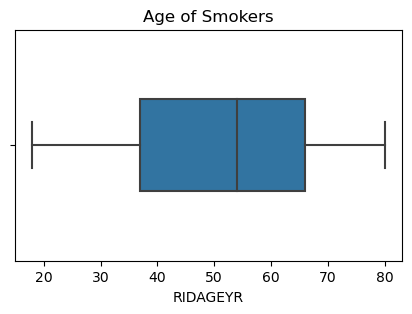

In [122]:
plt.figure(figsize=[5,3])
sns.boxplot(x=smokers_age, width=0.4)
plt.title('Age of Smokers');

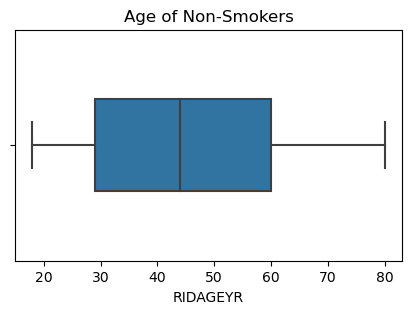

In [123]:
plt.figure(figsize=[5,3])
sns.boxplot(x=nonsmokers_age, width=0.4)
plt.title('Age of Non-Smokers');

#### Q6b. Does it appear that uncertainty about the mean age of smokers, or uncertainty about the mean age of non-smokers contributed more to the uncertainty for the mean difference that we are focusing on here?

Based on the given confidence interval result, the mean difference between the average age of smokers and non-smokers is estimated to be between 5.592 and 7.696 years. Since the confidence interval does not include zero, we can infer that the difference between the mean ages of smokers and non-smokers is statistically significant.

To determine whether uncertainty about the mean age of smokers or non-smokers contributed more to the uncertainty for the mean difference, we need to examine the confidence interval widths for each group. A wider confidence interval indicates more uncertainty about the mean for that group, and therefore more uncertainty about the difference between the means.

However, since we didn't calculate the widths, we cannot determine which group contributed more to the uncertainty for the mean difference based on the given information.